<div style="background-color: #B00E54; color: white; font-variant: small-caps; padding: 10px; text-align: center;">
  <span style="font-size: 14pt;">Part 04:</span>
  <span style="font-size: 26pt; font-weight: bold;"> Data Forecasting</span>
</div>

<div style="background-color: #B00E54; color: white; padding: 10px; text-align: center;">
  <span style="font-size: 14pt; font-weight: bold; font-color: #87B5D6"> Modeling and Predicting U.S. Border Entry Volumes </span><br>  
</div>

<div style="background-color: #C73876; padding: 10px; margin-top: 10px;">
  <b>Importing Python libraries and loading required dataset.</b>
</div>

In [126]:

import pandas as pd
import matplotlib.pyplot as plt
from prophet import Prophet
from datetime import datetime
import plotly.graph_objs as go
import matplotlib.dates as mdates

In [127]:

file_path_finalized_broder_crossing_df = '../Capstone Project/finalized_broder_crossing_df.csv'
finalized_broder_crossing_df = pd.read_csv(file_path_finalized_broder_crossing_df)
df = finalized_broder_crossing_df.copy()
print('"finalized_broder_crossing_df" is loaded.')

"finalized_broder_crossing_df" is loaded.


In [128]:

df = finalized_broder_crossing_df.groupby('Date')['Value'].sum().reset_index() # Aggregate by date
df.columns = ['ds', 'y'] # rename column
df['ds'] = pd.to_datetime(df['ds']) # convert date to datetime dtype
train = df[df['ds'].dt.year < 2020]  # filter only 2015–2019 data for model

model = Prophet() # initializing facebook model
model.fit(train) # training the dataset for future prediction

future = model.make_future_dataframe(periods=48, freq='MS')  # predict Jan–Dec 2020. 2021, 2022, 2023
forecast = model.predict(future)

07:25:36 - cmdstanpy - INFO - Chain [1] start processing
07:25:36 - cmdstanpy - INFO - Chain [1] done processing


In [129]:

actual_2020_monthly = df[df['ds'].dt.year.isin([2020, 2021, 2022, 2023])] # filtering data for the year 2020 to 2023 for comparision
predicted_2020_22 = forecast[forecast['ds'].dt.year > 2019] # fitering future predicted data from forcast

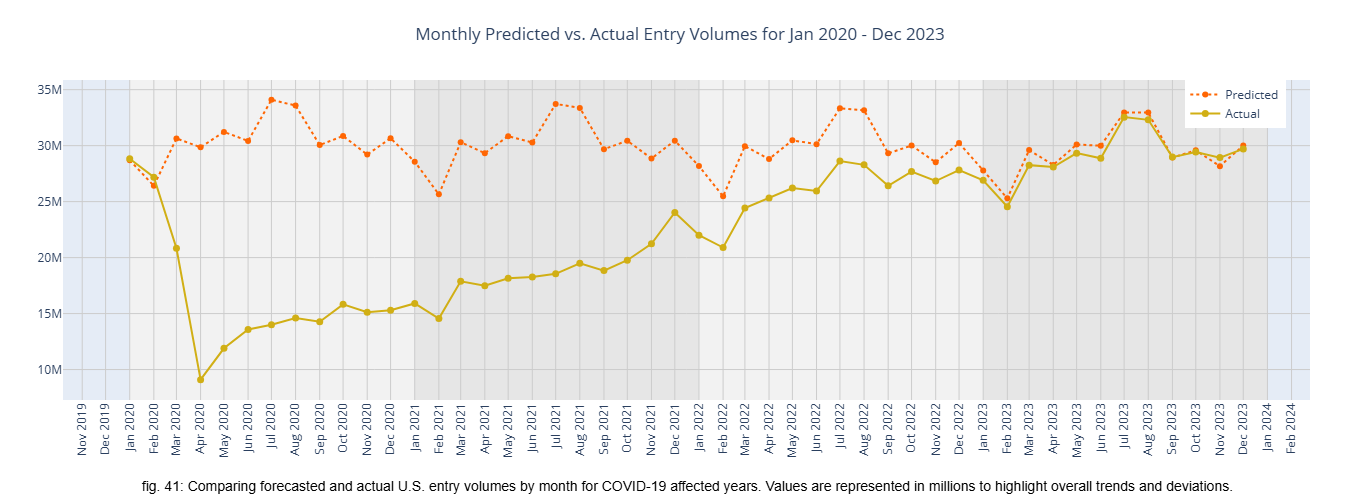

In [130]:

fig = go.Figure()

# plotting future predicted line
fig.add_trace(go.Scatter(
    x=predicted_2020_22['ds'], y=predicted_2020_22['yhat'], mode='lines+markers', name='Predicted', line=dict(color='#FF6603', dash='dot'), marker=dict(symbol='circle'), hoverinfo='skip'
))

# plotting original data line
fig.add_trace(go.Scatter(
    x=actual_2020_monthly['ds'], y=actual_2020_monthly['y'], mode='lines+markers', name='Actual', line=dict(color='#D1AF15'), marker=dict(symbol='circle', size=7), hoverinfo='skip'
))

# adding alternating background colors
year_colors = ['#F2F2F2', '#E6E6E6']  # light blue and light gray
start_year = 2020
end_year = 2023

shapes = []
for i, year in enumerate(range(start_year, end_year + 1)):
    shapes.append(dict(
        type="rect", xref="x", yref="paper", x0=datetime(year, 1, 1), x1=datetime(year + 1, 1, 1), y0=0, y1=1, fillcolor=year_colors[i % 2],
        opacity=1,  # increase opacity if too faint
        layer="below", line_width=0
    ))

fig.update_layout(
    shapes=shapes,
    title= dict( text='Monthly Predicted vs. Actual Entry Volumes for Jan 2020 - Dec 2023', x=0.5),
    xaxis=dict(
        title='', tickformat='%b %Y', tickangle=-90, dtick="M1", gridcolor='#CCCCCC'
    ),
    yaxis=dict(
        title='', gridcolor='#CCCCCC'
    ),
    legend=dict(x=0.9, y=1),
    margin=dict(l=50, r=50, t=80, b=100),
    height=500,
    width=1400
)

fig.add_annotation(
    text="fig. 41: Comparing forecasted and actual U.S. entry volumes by month for COVID-19 affected years. Values are represented in millions to highlight overall trends and deviations.",
    x=0.5,
    y=-0.3,  # bottom of the figure
    xref="paper",
    yref="paper",
    showarrow=False,
    font=dict(size=14, color='black', family='Arial'),
    xanchor='center',
    yanchor='bottom'
)

fig.show()


In [131]:

def format_millions(value):
    """Format number as rounded millions with 'M' suffix."""
    return f"{value / 1_000_000:.2f} M"

# Your existing code...
# Add datetime conversion
actual_2020_monthly.loc[:, 'ds'] = pd.to_datetime(actual_2020_monthly['ds'])
predicted_2020_22.loc[:, 'ds'] = pd.to_datetime(predicted_2020_22['ds'])

# Merge actual and forecast on date
merged_df = pd.merge(predicted_2020_22, actual_2020_monthly, on='ds', how='left')

# Extract April 2020 row
april_row = merged_df[merged_df['ds'] == '2020-04-01']

# Check if actual value exists for April
if april_row['y'].isnull().values[0]:
    print("No actual value available for April 2020.")
else:
    actual = april_row['y'].values[0]
    predicted = april_row['yhat'].values[0]
    difference = actual - predicted
    percent_diff = (difference / actual) * 100

    print(f" April 2020:")
    print(f" Actual: {actual:,.0f}  |  {format_millions(actual)}")
    print(f" Predicted: {predicted:,.0f} |  {format_millions(predicted)}")
    print(f" Difference: {difference:,.0f} |  {format_millions(difference)}")
    print(f" % Difference: {percent_diff:.2f}%")


 April 2020:
 Actual: 9,100,075  |  9.10 M
 Predicted: 29,855,718 |  29.86 M
 Difference: -20,755,643 |  -20.76 M
 % Difference: -228.08%


In [132]:

predicted_filtered = predicted_2020_22[['ds', 'yhat']]

merged_df = pd.merge(actual_2020_monthly, predicted_filtered, on='ds')

merged_df['difference'] = merged_df['y'] - merged_df['yhat']
merged_df['percentage'] = (merged_df['difference'] / merged_df['y']) * 100

merged_df['percentage'] = merged_df['percentage'].round(2)
#merged_df.head()

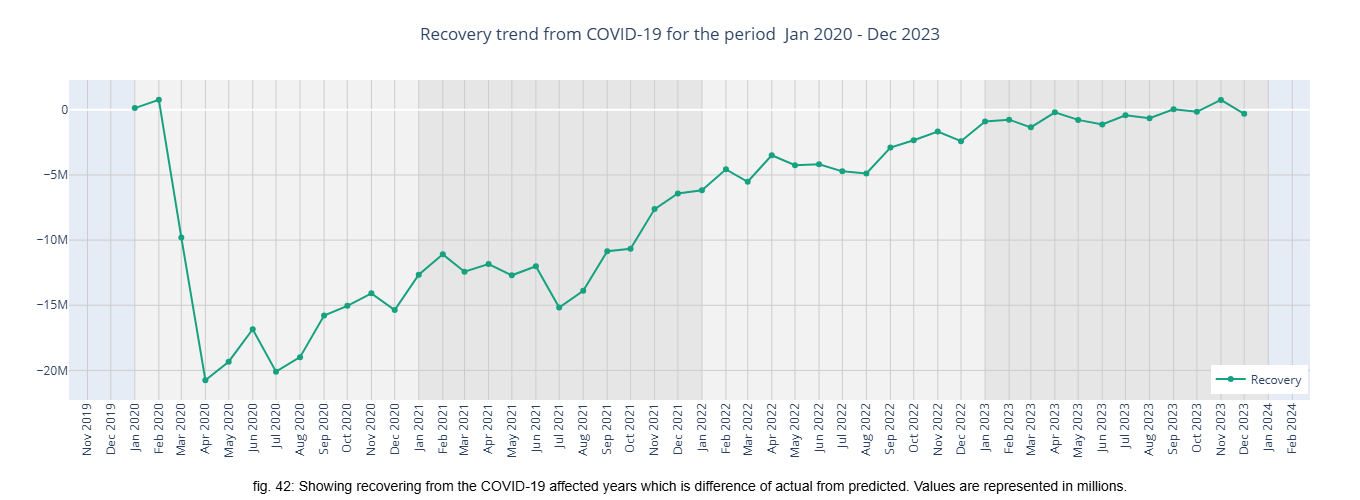

In [133]:

fig = go.Figure()

# plotting future predicted line
fig.add_trace(go.Scatter(
    x=predicted_2020_22['ds'], y=merged_df['difference'], mode='lines+markers', name='Recovery', line=dict(color='#16A180'), marker=dict(symbol='circle'), hoverinfo='skip', showlegend=True
))

# adding alternating background colors
year_colors = ['#F2F2F2', '#E6E6E6'] 
start_year = 2020
end_year = 2023

shapes = []
for i, year in enumerate(range(start_year, end_year + 1)):
    shapes.append(dict(
        type="rect", xref="x", yref="paper", x0=datetime(year, 1, 1), x1=datetime(year + 1, 1, 1), y0=0, y1=1, fillcolor=year_colors[i % 2],
        opacity=1,  # increase opacity if too faint
        layer="below", line_width=0
    ))

fig.update_layout(
    shapes=shapes,
    title= dict( text='Recovery trend from COVID-19 for the period  Jan 2020 - Dec 2023', x=0.5),
    xaxis=dict(
        title='', tickformat='%b %Y', tickangle=-90, dtick="M1", gridcolor='#CCCCCC'
    ),
    yaxis=dict(
        title='', gridcolor='#CCCCCC'
    ),
    legend=dict(x=0.92, y=0.02),
    margin=dict(l=50, r=50, t=80, b=100),
    height=500,
    width=1400
)

fig.add_annotation(
    text="fig. 42: Showing recovering from the COVID-19 affected years which is difference of actual from predicted. Values are represented in millions.",
    x=0.5,
    y=-0.3,  # bottom of the figure
    xref="paper",
    yref="paper",
    showarrow=False,
    font=dict(size=14, color='black', family='Arial'),
    xanchor='center',
    yanchor='bottom'
)

fig.show()


In [134]:

fig = go.Figure()

# Add bar trace for percentage
fig.add_trace(go.Bar(x=merged_df['ds'], y=merged_df['percentage'], name='Percentage Difference', marker_color='#16A180'
))

# Add alternating background colors for each year
year_colors = ['#F2F2F2', '#E6E6E6'] 
start_year = 2020
end_year = 2023

shapes = []
for i, year in enumerate(range(start_year, end_year + 1)):
    shapes.append(dict(
        type="rect",
        xref="x",
        yref="paper",
        x0=datetime(year, 1, 1),
        x1=datetime(year + 1, 1, 1),
        y0=0,
        y1=1,
        fillcolor=year_colors[i % 2],
        opacity=1,
        layer="below",
        line_width=0
    ))

# Layout settings with fixed x-axis range like your first plot
fig.update_layout(
    shapes=shapes,
    title=dict(
        text='Percentage Difference Between Actual and Predicted Entry Volumes',
        x=0.5
    ),
    xaxis=dict(
        title='',
        tickformat='%b %Y',
        tickangle=-90,
        dtick="M1",
        gridcolor='#CCCCCC',
        range=[datetime(2019, 10, 1), datetime(2024, 2, 29)]  # Fix x-axis range here
    ),
    yaxis=dict(
        title='Percentage (%)',
        gridcolor='#CCCCCC'
    ),
    legend=dict(x=0.9, y=1),
    margin=dict(l=50, r=50, t=80, b=100),
    height=500,
    width=1400
)

# Optional annotation, like your first plot
fig.add_annotation(
    text="fig. 43: Monthly percentage difference between actual and predicted U.S. entry volumes.",
    x=0.5,
    y=-0.3,
    xref="paper",
    yref="paper",
    showarrow=False,
    font=dict(size=14, color='black', family='Arial'),
    xanchor='center',
    yanchor='bottom'
)

fig.show()


In [135]:

# Create and fit the model
model = Prophet()
model.fit(df)

07:25:36 - cmdstanpy - INFO - Chain [1] start processing
07:25:37 - cmdstanpy - INFO - Chain [1] done processing


In [136]:

future_24Months = model.make_future_dataframe(periods=24, freq='MS')  # Create a dataframe with future dates (next 12 months), 'MS' = month start 
forecast_24Months = model.predict(future_24Months) # forecast year 2025 and 2026

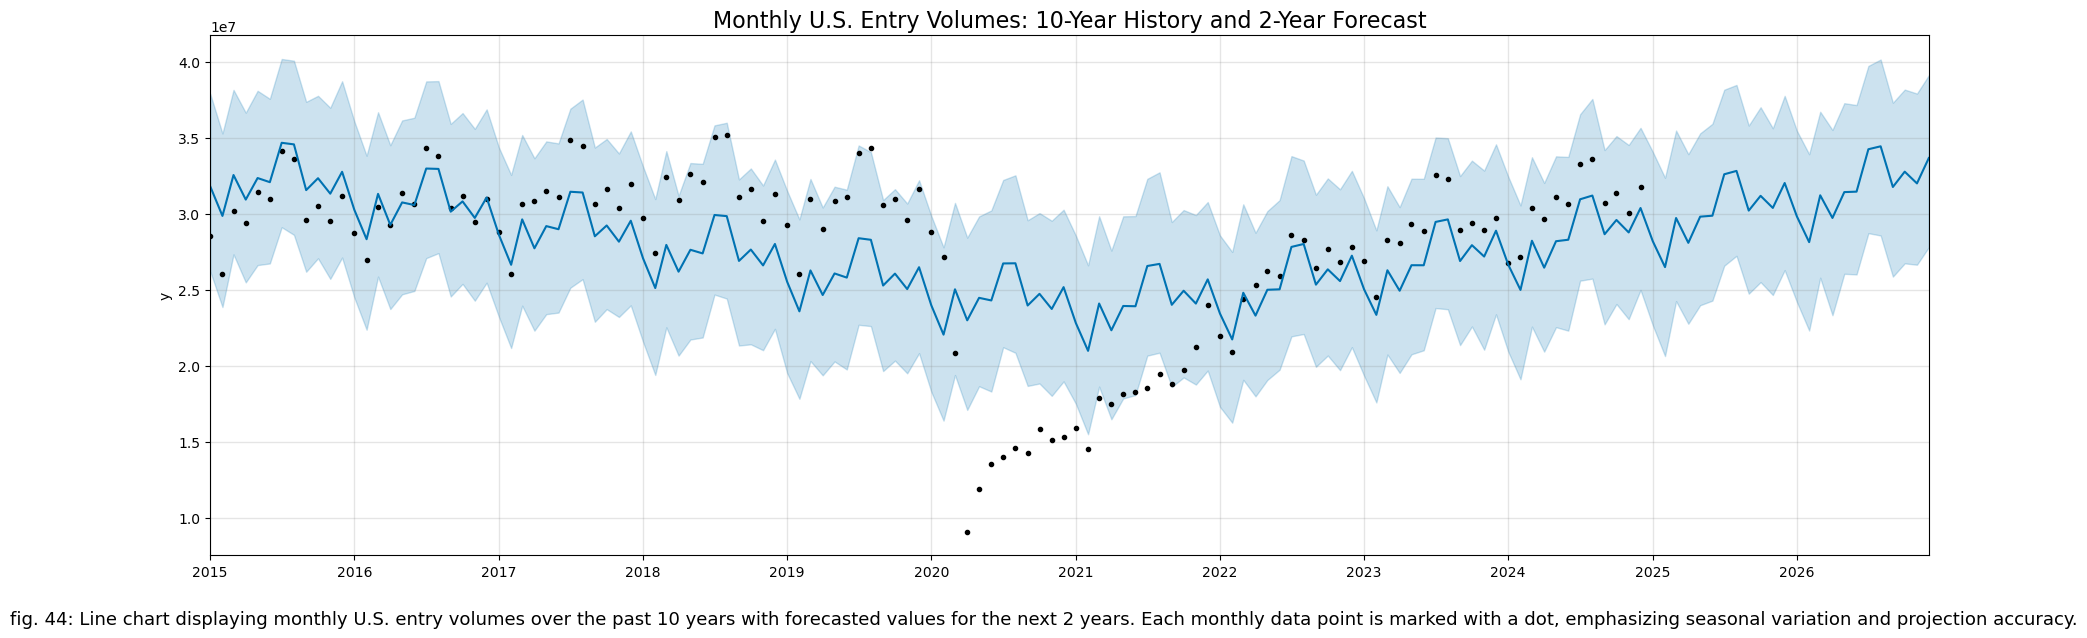

In [137]:

# Create the Prophet plot and get the axes
fig = model.plot(forecast_24Months)
ax = fig.gca()

# Set figure size: width=12 inches, height=6 inches
fig.set_size_inches(18, 6)

# Add title
ax.set_title('Monthly U.S. Entry Volumes: 10-Year History and 2-Year Forecast', fontsize=16)

# Set x-axis to show every year
ax.xaxis.set_major_locator(mdates.YearLocator(1))  # 1 = every year
ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y'))

df['ds'] = pd.to_datetime(df['ds'])
forecast_24Months['ds'] = pd.to_datetime(forecast_24Months['ds'])
# Get the earliest and latest dates
start_date = df['ds'].min()
end_date = forecast_24Months['ds'].max()
ax.set_xlim([start_date, end_date])  # tighter limits
ax.set_xlabel('')

# Optional: rotate for readability
plt.setp(ax.get_xticklabels(), rotation=0)

# Optional: Adjust layout
plt.tight_layout()
# Add caption/subtitle at bottom center
fig.text(0.5, -0.05, 'fig. 44: Line chart displaying monthly U.S. entry volumes over the past 10 years with forecasted values for the next 2 years. Each monthly data point is marked with a dot, emphasizing seasonal variation and projection accuracy.', ha='center', fontsize=13)
plt.show()

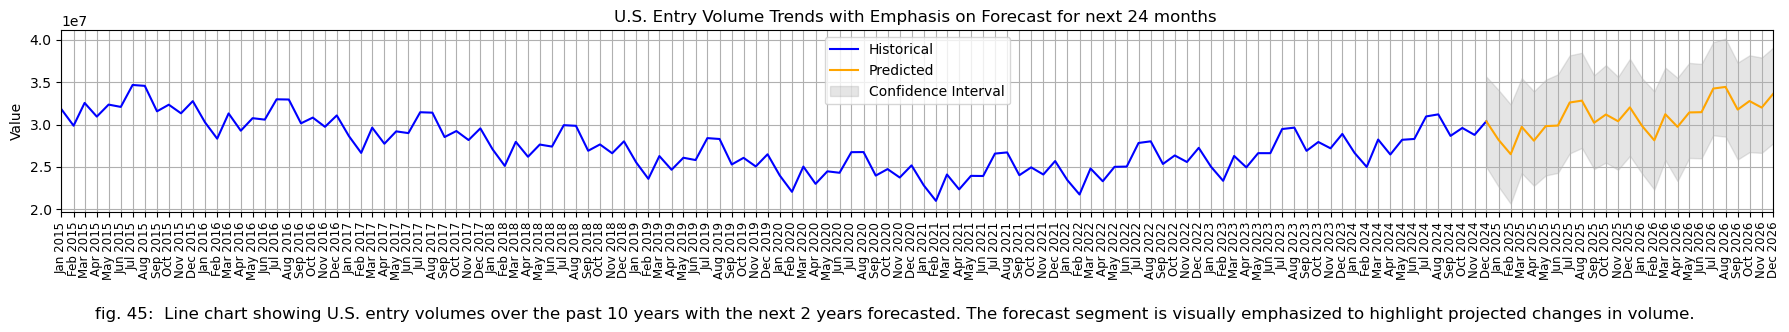

In [138]:

# Separate historical and forecast data
historical_24Months = forecast_24Months[forecast_24Months['ds'] <= df['ds'].max()]
future_forecast_24Months = forecast_24Months[forecast_24Months['ds'] >= df['ds'].max()]

plt.figure(figsize=(18, 3))

# Plot fitted and forecast lines
plt.plot(historical_24Months['ds'], historical_24Months['yhat'], label='Historical', color='blue')
plt.plot(future_forecast_24Months['ds'], future_forecast_24Months['yhat'], label='Predicted', color='orange')

# Confidence interval shading
plt.fill_between(future_forecast_24Months['ds'],
                 future_forecast_24Months['yhat_lower'],
                 future_forecast_24Months['yhat_upper'],
                 color='gray', alpha=0.2, label='Confidence Interval')

# Set axis limits to remove extra whitespace
plt.xlim(df['ds'].min(), future_forecast_24Months['ds'].max())

# Format x-axis to show all months
ax = plt.gca()
ax.xaxis.set_major_locator(mdates.MonthLocator())  # every month
ax.xaxis.set_major_formatter(mdates.DateFormatter('%b %Y'))  # e.g. Jan 2024

# Rotate x-axis labels for readability
plt.xticks(rotation=90, fontsize=8.5)

# Titles, labels, legend, grid
plt.title('U.S. Entry Volume Trends with Emphasis on Forecast for next 24 months ')
#plt.xlabel('Date')
plt.ylabel('Value')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.figtext(0.5, -0.08, 'fig. 45:  Line chart showing U.S. entry volumes over the past 10 years with the next 2 years forecasted. The forecast segment is visually emphasized to highlight projected changes in volume.', ha='center', fontsize=12, fontstyle='normal')
plt.show()
